In [152]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import argparse
import os
from pathlib import Path
import json
import re
import numpy as np
import importlib
from typing import Callable, Any
OUTPUT_DIR = "graficos"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:

ALGORITHMS = {}
ALGORITHMS['cryptography'] = {
    'ecdsa': {
        1: 'P-256',
        3: 'P-384',
        5: 'P-521'
    },
}

ALGORITHMS['liboqs'] =  {
    'mldsa': {
        1: 'ML-DSA-44',
        2: 'ML-DSA-44',
        3: 'ML-DSA-65',
        5: 'ML-DSA-87'
    },
    'dilithium': {
        1: 'Dilithium2',
        2: 'Dilithium2',
        3: 'Dilithium3',
        5: 'Dilithium5'
    },
    'sphincs-sha-s': {
        1: 'SPHINCS+-SHA2-128s-simple',
        3: 'SPHINCS+-SHA2-192s-simple',
        5: 'SPHINCS+-SHA2-256s-simple'
    },
    'sphincs-sha-f': {
        1: 'SPHINCS+-SHA2-128f-simple',
        3: 'SPHINCS+-SHA2-192f-simple',
        5: 'SPHINCS+-SHA2-256f-simple'
    },
    'sphincs-shake-s': {
        1: 'SPHINCS+-SHAKE-128s-simple',
        3: 'SPHINCS+-SHAKE-192s-simple',
        5: 'SPHINCS+-SHAKE-256s-simple'
    },
    'sphincs-shake-f': {
        1: 'SPHINCS+-SHAKE-128f-simple',
        3: 'SPHINCS+-SHAKE-192f-simple',
        5: 'SPHINCS+-SHAKE-256f-simple'
    },
    'falcon': {
        1: 'Falcon-512',
        5: 'Falcon-1024'
    },
    'falcon-padded': {
        1: 'Falcon-padded-512',
        5: 'Falcon-padded-1024'
    },
    'mayo': {
        1: 'MAYO-2',
        3: 'MAYO-3',
        5: 'MAYO-5'
    },
    'cross-rsdp-small': {
        1: 'cross-rsdp-128-small',
        3: 'cross-rsdp-192-small',
        5: 'cross-rsdp-256-small'
    },
    'cross-rsdpg-small': {
        1: 'cross-rsdpg-128-small',
        3: 'cross-rsdpg-192-small',
        5: 'cross-rsdpg-256-small'
    },
    'cross-rsdp-balanced': {
        1: 'cross-rsdp-128-balanced',
        3: 'cross-rsdp-192-balanced',
        5: 'cross-rsdp-256-balanced'
    },
    'cross-rsdpg-balanced': {
        1: 'cross-rsdpg-128-balanced',
        3: 'cross-rsdpg-192-balanced',
        5: 'cross-rsdpg-256-balanced'
    },
    'cross-rsdp-fast': {
        1: 'cross-rsdp-128-fast',
        3: 'cross-rsdp-192-fast',
        5: 'cross-rsdp-256-fast'
    },
    'cross-rsdpg-fast': {
        1: 'cross-rsdpg-128-fast',
        3: 'cross-rsdpg-192-fast',
        5: 'cross-rsdpg-256-fast'
    }
}


In [154]:
def ensure_output_dir(output_dir):
    """
    Checks if OUTPUT_DIR exists, and creates it if not.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    else:
        print(f"Directory already exists: {output_dir}")

ensure_output_dir(OUTPUT_DIR)

Directory already exists: graficos


In [165]:
def find_csv_recursive(root_dir, filename):
    """
    Recursively search for a file named `filename` in `root_dir`.
    Returns the full path if found, else None.
    """
    for dirpath, _, files in os.walk(root_dir):
        if filename in files:
            return os.path.join(dirpath, filename)
    return None

def load_results(input_dir,  index_col="variant"):
    """
    Loads CSV data from each subdirectory in input_dir.
    Returns a dictionary:
    {
        'subdir_name': {
            'time-evaluation-tmean-std': pd.DataFrame,
            'blocksim-mean-std': pd.DataFrame
        },
        ...
    }
    """
    results = {}
    for subdir in os.listdir(input_dir):
        subdir_path = os.path.join(input_dir, subdir)
        if os.path.isdir(subdir_path):
            data = {}
            for key in ['time-evaluation-mean-std', 'blocksim-mean-std', 'blocksim-mean-std', 'blocksim-model-2-mean-std', 'blocksim-model-1-mean-std']:
                csv_path = find_csv_recursive(subdir_path, f"{key}.csv")
                if csv_path:
                    data[key] = pd.read_csv(csv_path, index_col=index_col)
                else:
                    data[key] = None  # or pd.DataFrame() if preferred
            results[subdir] = data
    return results

results = load_results("results-paper")
print(results)  # Print the keys to verify loading

{'deeppurple': {'time-evaluation-mean-std':                             mean_keypair  std_keypair   mean_sign  std_sign  \
variant                                                                       
P-256                           0.014985     0.001014    0.032987  0.001618   
P-384                           0.121796     0.004539    0.199208  0.006688   
P-521                           0.108694     0.002671    0.224251  0.004228   
ML-DSA-44                       0.023557     0.000803    0.055254  0.029745   
ML-DSA-65                       0.038660     0.001662    0.087317  0.047264   
ML-DSA-87                       0.060452     0.001855    0.107145  0.045544   
Dilithium2                      0.023368     0.000804    0.054768  0.030060   
Dilithium3                      0.038603     0.000752    0.085991  0.045909   
Dilithium5                      0.060491     0.001053    0.108599  0.046677   
SPHINCS+-SHA2-128s-simple      15.154873     0.052452  115.226658  0.232324   
SPHINCS+

In [156]:
def get_variants_by_level(df, variant_dict):
    csv_variants = set(df.index.to_list())
    print("CSV Variants:", csv_variants)
    variants_by_level = {}

    for algorithm, levels in variant_dict.items():
        for level, variant in levels.items():
            if variant in csv_variants:
                variants_by_level.setdefault(level, []).append({
                    "algorithm": algorithm,
                    "variant": variant
                })
             
    return dict(sorted(variants_by_level.items()))

def filter_algorithms(algorithms: dict, selected_algorithms: list = None, selected_levels: list = None) -> dict:
    selected_algorithms = selected_algorithms or []
    selected_levels = selected_levels or []

    filtered = {}

    for module, algos in algorithms.items():
        for algorithm, variants in algos.items():
            if selected_algorithms and algorithm not in selected_algorithms:
                continue

            selected_variants = {
                level: name for level, name in variants.items()
                if not selected_levels or level in selected_levels
            }

            if selected_variants:
                filtered.setdefault(module, {})[algorithm] = selected_variants

    return filtered


All algorithms loaded: ['cryptography', 'liboqs']
Filtered algorithms: {'cryptography': {'ecdsa': {1: 'P-256', 3: 'P-384', 5: 'P-521'}}, 'liboqs': {'mldsa': {1: 'ML-DSA-44', 3: 'ML-DSA-65', 5: 'ML-DSA-87'}, 'mayo': {1: 'MAYO-2', 3: 'MAYO-3', 5: 'MAYO-5'}}}
Combined mechanisms: {'ecdsa': {1: 'P-256', 3: 'P-384', 5: 'P-521'}, 'mldsa': {1: 'ML-DSA-44', 3: 'ML-DSA-65', 5: 'ML-DSA-87'}, 'mayo': {1: 'MAYO-2', 3: 'MAYO-3', 5: 'MAYO-5'}}
CSV Variants: {'SPHINCS+-SHAKE-192s-simple', 'MAYO-5', 'cross-rsdpg-256-fast', 'SPHINCS+-SHA2-128s-simple', 'Falcon-1024', 'P-384', 'cross-rsdpg-192-fast', 'SPHINCS+-SHA2-192s-simple', 'SPHINCS+-SHAKE-128s-simple', 'cross-rsdpg-256-balanced', 'ML-DSA-65', 'cross-rsdp-192-balanced', 'Dilithium2', 'SPHINCS+-SHA2-256f-simple', 'MAYO-3', 'P-256', 'SPHINCS+-SHA2-256s-simple', 'cross-rsdp-256-small', 'cross-rsdpg-192-small', 'cross-rsdp-128-balanced', 'cross-rsdp-192-small', 'cross-rsdp-128-small', 'cross-rsdp-128-fast', 'cross-rsdpg-192-balanced', 'Dilithium3', 'SP

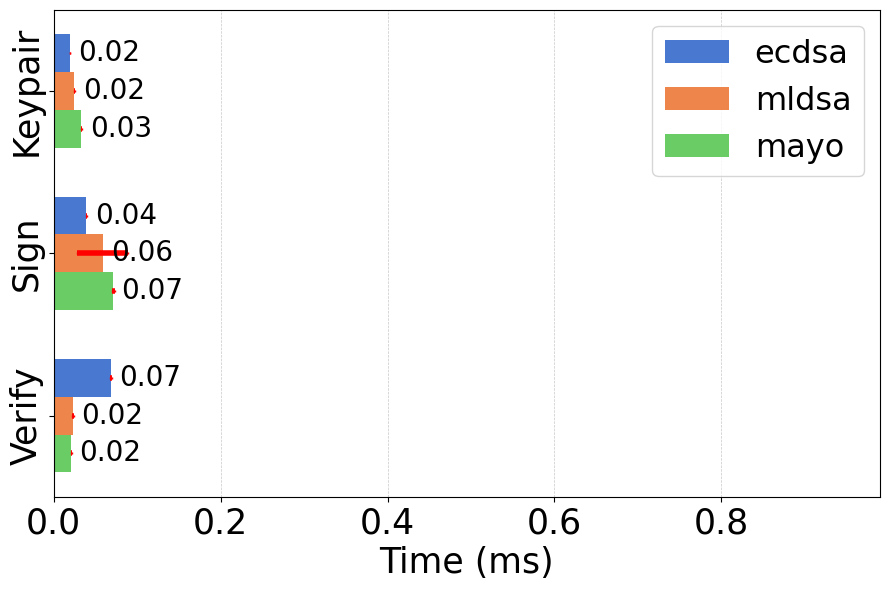

Processing a9, level 3
Final algorithms: ['ecdsa', 'mldsa', 'mayo']
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
Saved: graficos/bench_a9_level-3.pdf


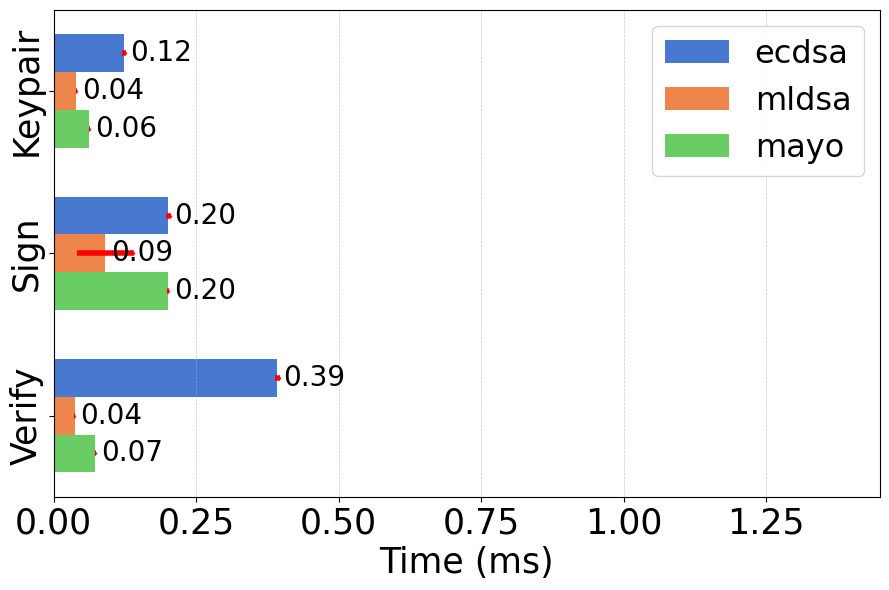

Processing a9, level 5
Final algorithms: ['ecdsa', 'mldsa', 'mayo']
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
Saved: graficos/bench_a9_level-5.pdf


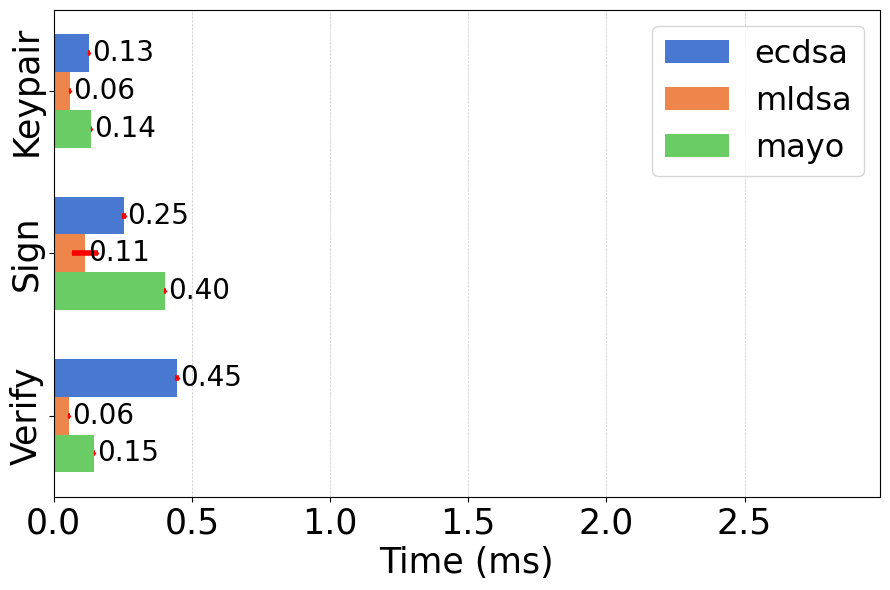

CSV Variants: {'SPHINCS+-SHAKE-192s-simple', 'MAYO-5', 'cross-rsdpg-256-fast', 'SPHINCS+-SHA2-128s-simple', 'Falcon-1024', 'P-384', 'cross-rsdpg-192-fast', 'SPHINCS+-SHA2-192s-simple', 'SPHINCS+-SHAKE-128s-simple', 'cross-rsdpg-256-balanced', 'ML-DSA-65', 'cross-rsdp-192-balanced', 'Dilithium2', 'SPHINCS+-SHA2-256f-simple', 'MAYO-3', 'P-256', 'SPHINCS+-SHA2-256s-simple', 'cross-rsdp-256-small', 'cross-rsdpg-192-small', 'cross-rsdp-128-balanced', 'cross-rsdp-192-small', 'cross-rsdp-128-small', 'cross-rsdp-128-fast', 'cross-rsdpg-192-balanced', 'Dilithium3', 'SPHINCS+-SHAKE-256f-simple', 'cross-rsdp-192-fast', 'cross-rsdp-256-balanced', 'SPHINCS+-SHA2-192f-simple', 'MAYO-2', 'Falcon-padded-512', 'cross-rsdpg-128-fast', 'cross-rsdpg-256-small', 'Falcon-512', 'SPHINCS+-SHAKE-192f-simple', 'Falcon-padded-1024', 'P-521', 'cross-rsdpg-128-balanced', 'SPHINCS+-SHAKE-128f-simple', 'ML-DSA-44', 'cross-rsdpg-128-small', 'SPHINCS+-SHAKE-256s-simple', 'cross-rsdp-256-fast', 'ML-DSA-87', 'Dilithium5

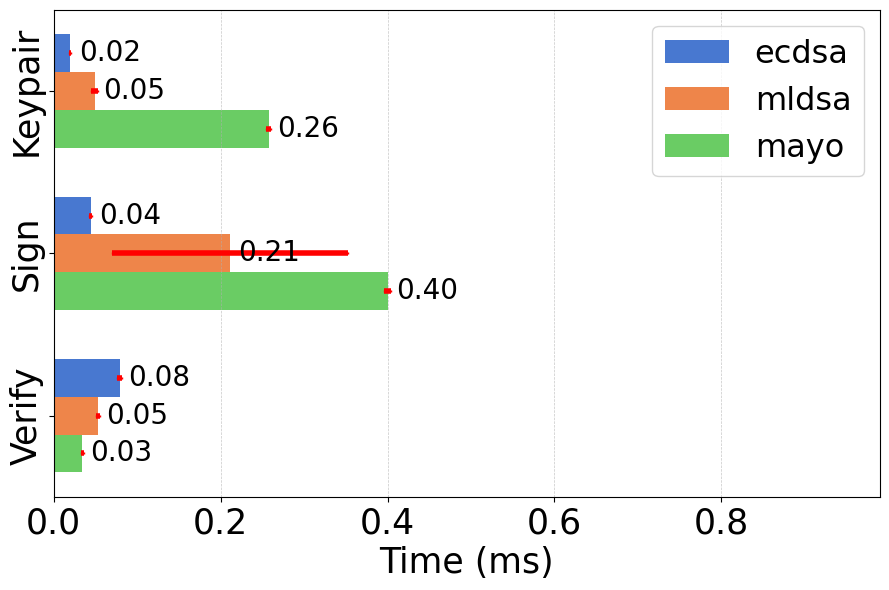

Processing airm1, level 3
Final algorithms: ['ecdsa', 'mldsa', 'mayo']
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
Saved: graficos/bench_airm1_level-3.pdf


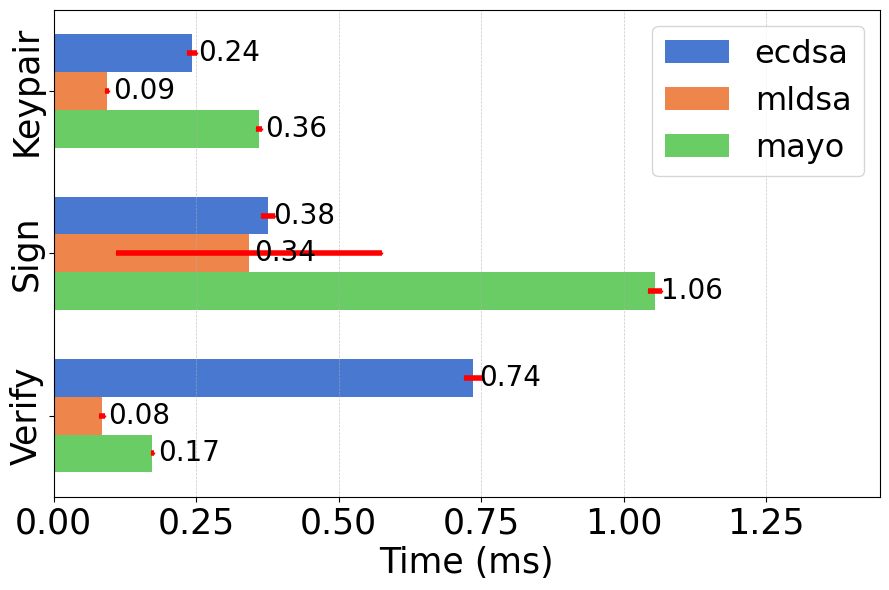

Processing airm1, level 5
Final algorithms: ['ecdsa', 'mldsa', 'mayo']
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
Saved: graficos/bench_airm1_level-5.pdf


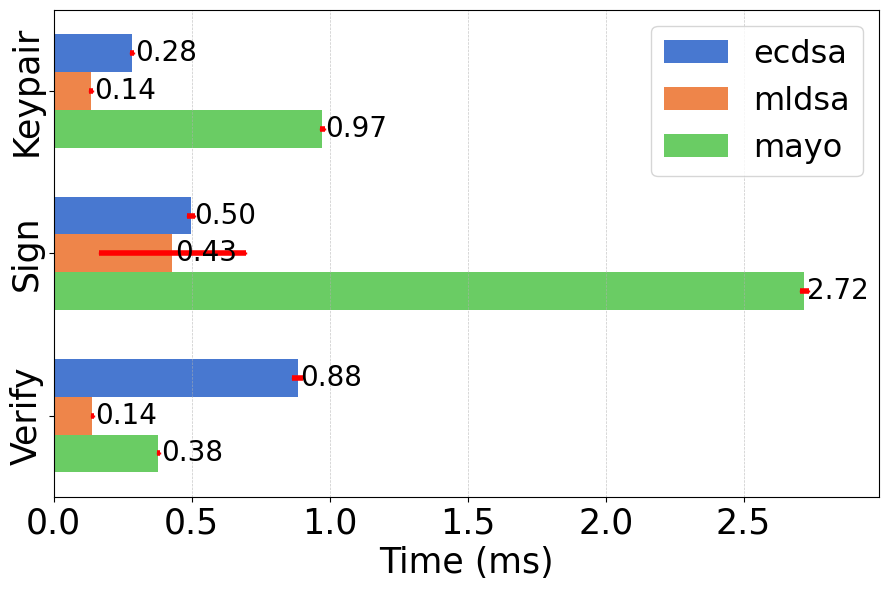

CSV Variants: {'SPHINCS+-SHAKE-192s-simple', 'MAYO-5', 'cross-rsdpg-256-fast', 'SPHINCS+-SHA2-128s-simple', 'Falcon-1024', 'P-384', 'cross-rsdpg-192-fast', 'SPHINCS+-SHA2-192s-simple', 'SPHINCS+-SHAKE-128s-simple', 'cross-rsdpg-256-balanced', 'ML-DSA-65', 'cross-rsdp-192-balanced', 'Dilithium2', 'SPHINCS+-SHA2-256f-simple', 'MAYO-3', 'P-256', 'SPHINCS+-SHA2-256s-simple', 'cross-rsdp-256-small', 'cross-rsdpg-192-small', 'cross-rsdp-128-balanced', 'cross-rsdp-192-small', 'cross-rsdp-128-small', 'cross-rsdp-128-fast', 'cross-rsdpg-192-balanced', 'Dilithium3', 'SPHINCS+-SHAKE-256f-simple', 'cross-rsdp-192-fast', 'cross-rsdp-256-balanced', 'SPHINCS+-SHA2-192f-simple', 'MAYO-2', 'Falcon-padded-512', 'cross-rsdpg-128-fast', 'cross-rsdpg-256-small', 'Falcon-512', 'SPHINCS+-SHAKE-192f-simple', 'Falcon-padded-1024', 'P-521', 'cross-rsdpg-128-balanced', 'SPHINCS+-SHAKE-128f-simple', 'ML-DSA-44', 'cross-rsdpg-128-small', 'SPHINCS+-SHAKE-256s-simple', 'cross-rsdp-256-fast', 'ML-DSA-87', 'Dilithium5

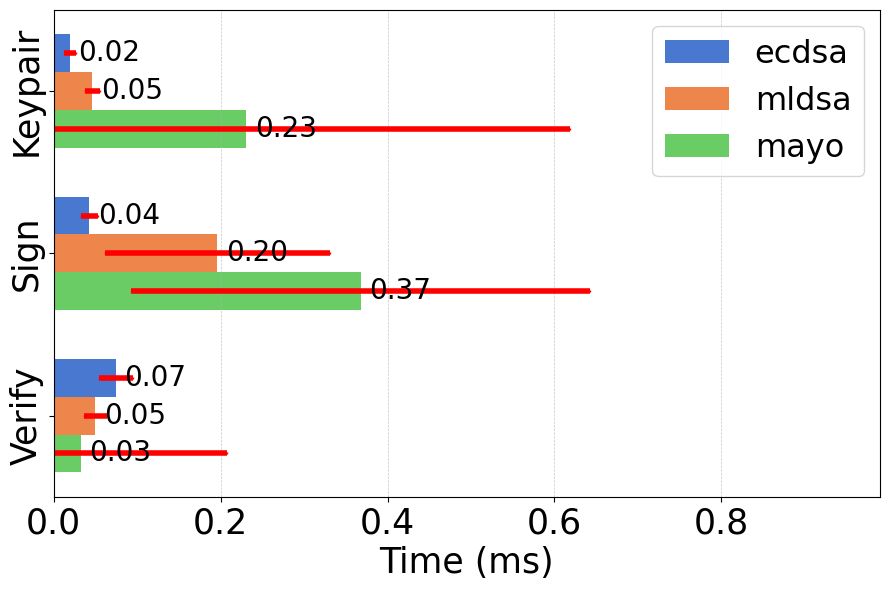

Processing airm2, level 3
Final algorithms: ['ecdsa', 'mldsa', 'mayo']
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
Saved: graficos/bench_airm2_level-3.pdf


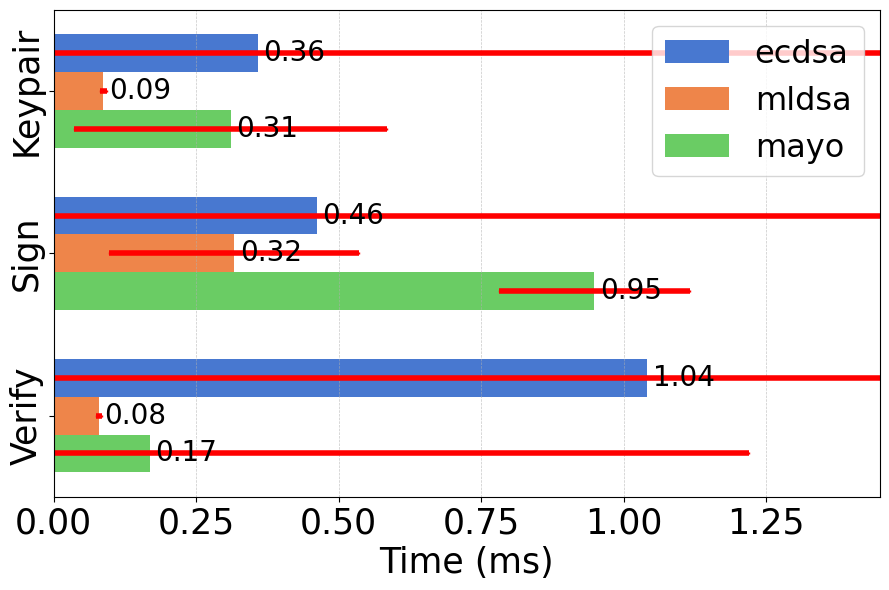

Processing airm2, level 5
Final algorithms: ['ecdsa', 'mldsa', 'mayo']
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
Saved: graficos/bench_airm2_level-5.pdf


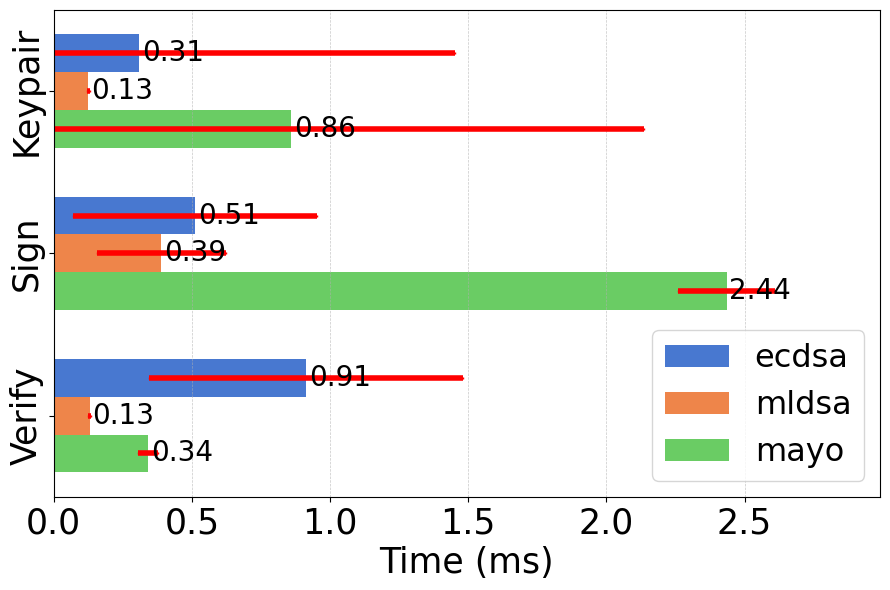

CSV Variants: {'SPHINCS+-SHAKE-192s-simple', 'MAYO-5', 'cross-rsdpg-256-fast', 'SPHINCS+-SHA2-128s-simple', 'Falcon-1024', 'cross-rsdpg-192-fast', 'P-384', 'SPHINCS+-SHA2-192s-simple', 'SPHINCS+-SHAKE-128s-simple', 'cross-rsdpg-256-balanced', 'ML-DSA-65', 'cross-rsdp-192-balanced', 'Dilithium2', 'SPHINCS+-SHA2-256f-simple', 'MAYO-3', 'P-256', 'SPHINCS+-SHA2-256s-simple', 'cross-rsdp-256-small', 'cross-rsdpg-192-small', 'cross-rsdp-128-balanced', 'cross-rsdp-192-small', 'cross-rsdp-128-small', 'cross-rsdp-128-fast', 'cross-rsdpg-192-balanced', 'Dilithium3', 'SPHINCS+-SHAKE-256f-simple', 'cross-rsdp-192-fast', 'cross-rsdp-256-balanced', 'SPHINCS+-SHA2-192f-simple', 'MAYO-2', 'Falcon-padded-512', 'cross-rsdpg-128-fast', 'cross-rsdpg-256-small', 'Falcon-512', 'SPHINCS+-SHAKE-192f-simple', 'Falcon-padded-1024', 'cross-rsdpg-128-balanced', 'P-521', 'SPHINCS+-SHAKE-128f-simple', 'ML-DSA-44', 'cross-rsdpg-128-small', 'SPHINCS+-SHAKE-256s-simple', 'cross-rsdp-256-fast', 'ML-DSA-87', 'Dilithium5

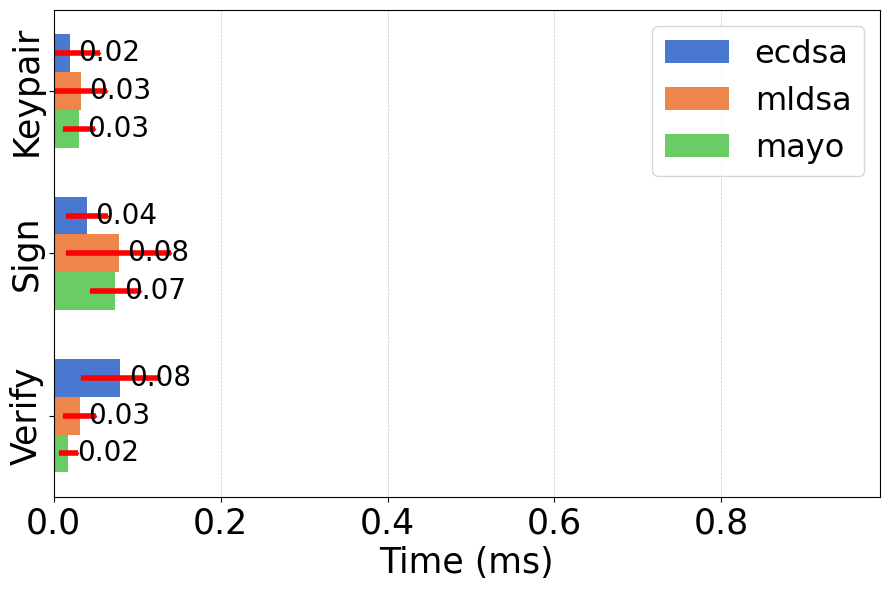

Processing laptop-windows-wsl, level 3
Final algorithms: ['ecdsa', 'mldsa', 'mayo']
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
Saved: graficos/bench_laptop-windows-wsl_level-3.pdf


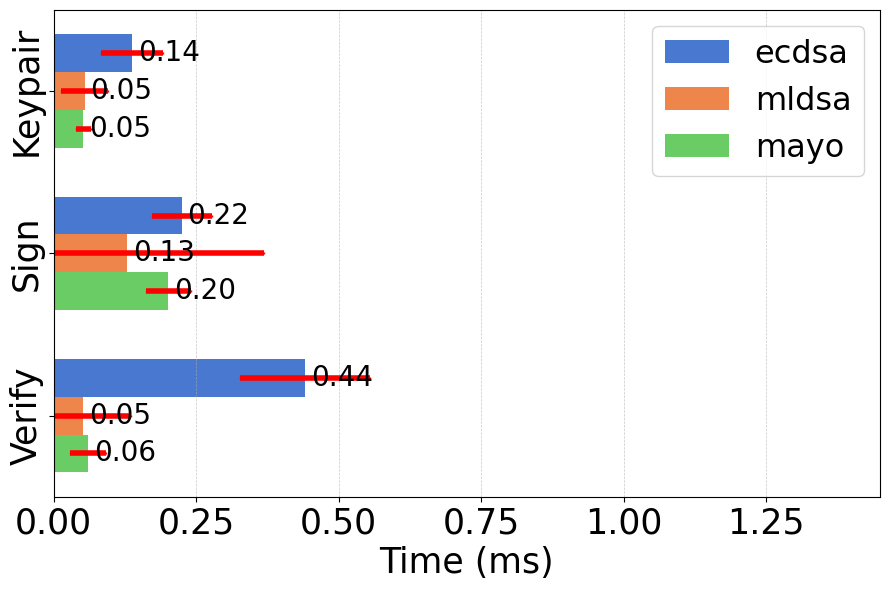

Processing laptop-windows-wsl, level 5
Final algorithms: ['ecdsa', 'mldsa', 'mayo']
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
Saved: graficos/bench_laptop-windows-wsl_level-5.pdf


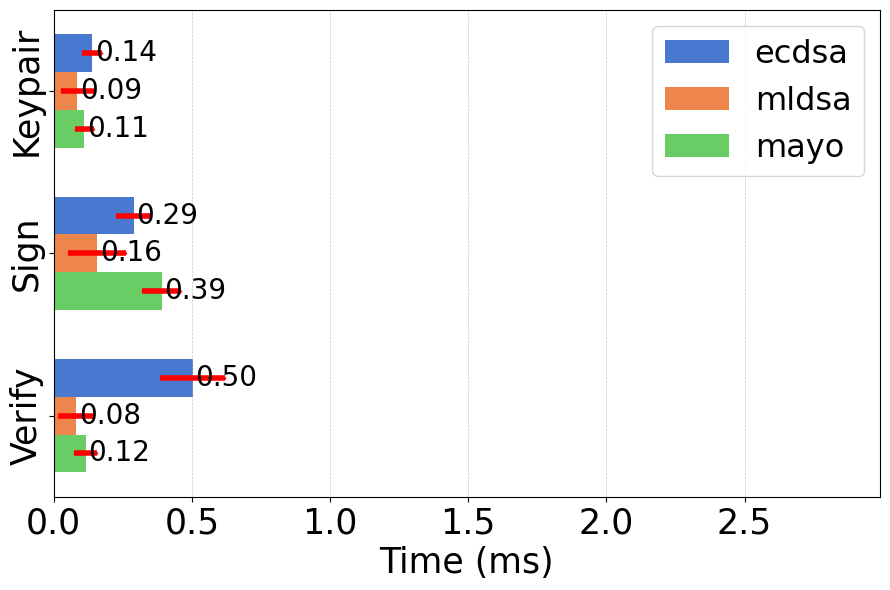

CSV Variants: {'SPHINCS+-SHAKE-192s-simple', 'MAYO-5', 'cross-rsdpg-256-fast', 'SPHINCS+-SHA2-128s-simple', 'Falcon-1024', 'P-384', 'cross-rsdpg-192-fast', 'SPHINCS+-SHA2-192s-simple', 'SPHINCS+-SHAKE-128s-simple', 'cross-rsdpg-256-balanced', 'ML-DSA-65', 'cross-rsdp-192-balanced', 'Dilithium2', 'SPHINCS+-SHA2-256f-simple', 'MAYO-3', 'P-256', 'SPHINCS+-SHA2-256s-simple', 'cross-rsdp-256-small', 'cross-rsdpg-192-small', 'cross-rsdp-128-balanced', 'cross-rsdp-192-small', 'cross-rsdp-128-small', 'cross-rsdp-128-fast', 'cross-rsdpg-192-balanced', 'Dilithium3', 'SPHINCS+-SHAKE-256f-simple', 'cross-rsdp-192-fast', 'cross-rsdp-256-balanced', 'SPHINCS+-SHA2-192f-simple', 'MAYO-2', 'Falcon-padded-512', 'cross-rsdpg-128-fast', 'cross-rsdpg-256-small', 'Falcon-512', 'SPHINCS+-SHAKE-192f-simple', 'Falcon-padded-1024', 'P-521', 'cross-rsdpg-128-balanced', 'SPHINCS+-SHAKE-128f-simple', 'ML-DSA-44', 'cross-rsdpg-128-small', 'SPHINCS+-SHAKE-256s-simple', 'cross-rsdp-256-fast', 'ML-DSA-87', 'Dilithium5

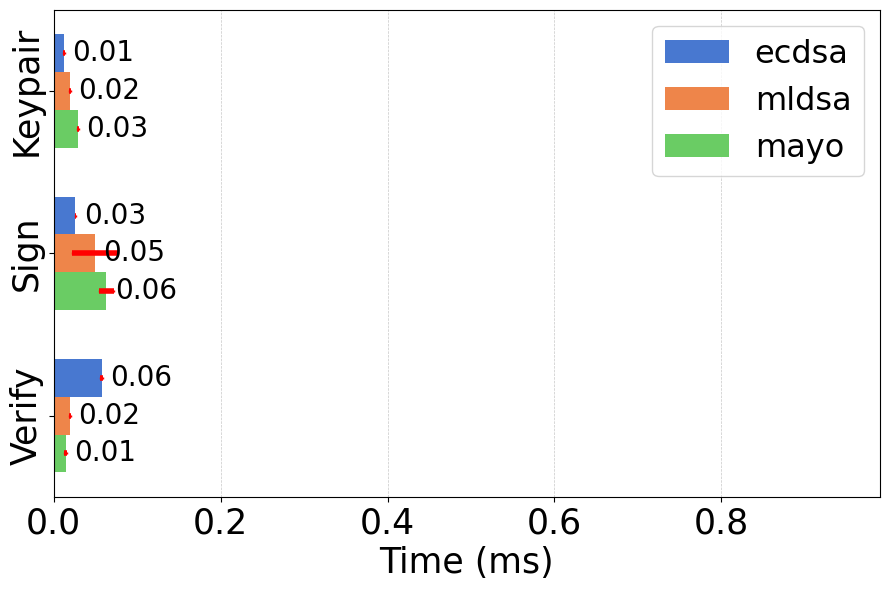

Processing xps-9320, level 3
Final algorithms: ['ecdsa', 'mldsa', 'mayo']
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
Saved: graficos/bench_xps-9320_level-3.pdf


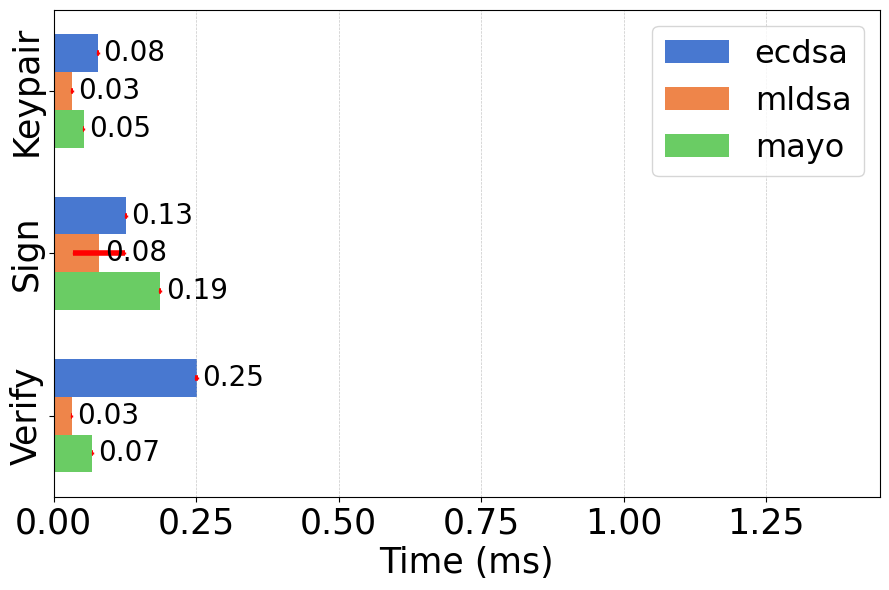

Processing xps-9320, level 5
Final algorithms: ['ecdsa', 'mldsa', 'mayo']
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
Saved: graficos/bench_xps-9320_level-5.pdf


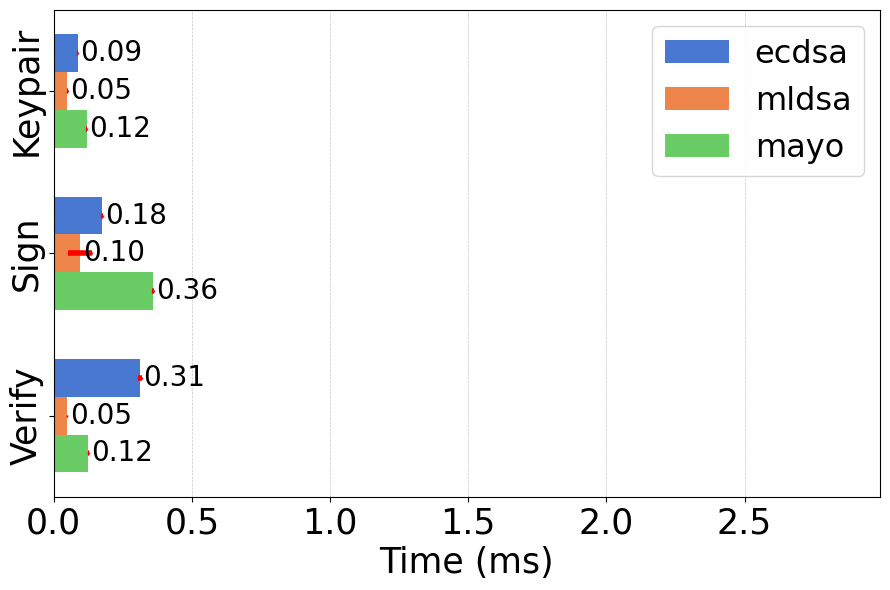

CSV Variants: {'SPHINCS+-SHAKE-192s-simple', 'MAYO-5', 'cross-rsdpg-256-fast', 'SPHINCS+-SHA2-128s-simple', 'Falcon-1024', 'P-384', 'cross-rsdpg-192-fast', 'SPHINCS+-SHA2-192s-simple', 'SPHINCS+-SHAKE-128s-simple', 'cross-rsdpg-256-balanced', 'ML-DSA-65', 'cross-rsdp-192-balanced', 'Dilithium2', 'SPHINCS+-SHA2-256f-simple', 'MAYO-3', 'P-256', 'SPHINCS+-SHA2-256s-simple', 'cross-rsdp-256-small', 'cross-rsdpg-192-small', 'cross-rsdp-128-balanced', 'cross-rsdp-192-small', 'cross-rsdp-128-small', 'cross-rsdp-128-fast', 'cross-rsdpg-192-balanced', 'Dilithium3', 'SPHINCS+-SHAKE-256f-simple', 'cross-rsdp-192-fast', 'cross-rsdp-256-balanced', 'SPHINCS+-SHA2-192f-simple', 'MAYO-2', 'Falcon-padded-512', 'cross-rsdpg-128-fast', 'cross-rsdpg-256-small', 'Falcon-512', 'SPHINCS+-SHAKE-192f-simple', 'Falcon-padded-1024', 'P-521', 'cross-rsdpg-128-balanced', 'SPHINCS+-SHAKE-128f-simple', 'ML-DSA-44', 'cross-rsdpg-128-small', 'SPHINCS+-SHAKE-256s-simple', 'cross-rsdp-256-fast', 'ML-DSA-87', 'Dilithium5

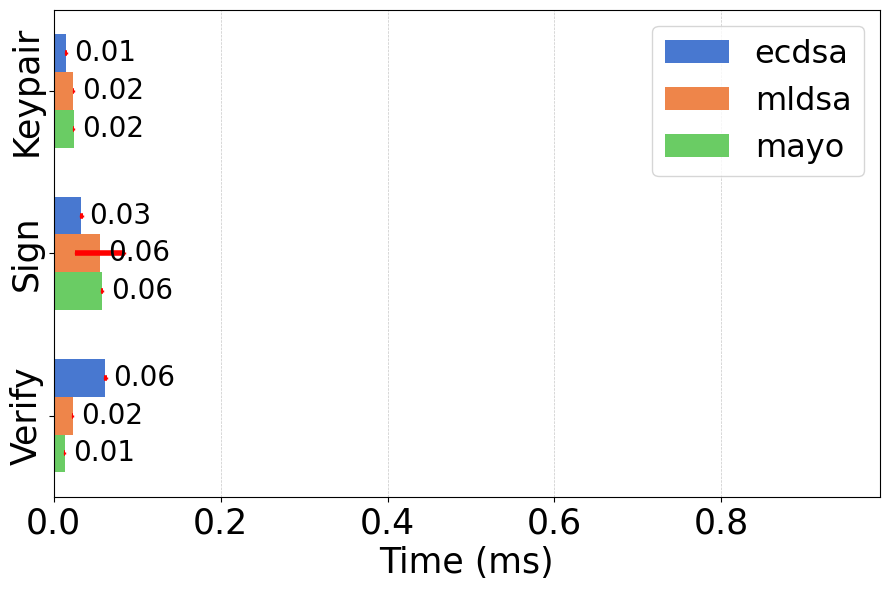

Processing deeppurple, level 3
Final algorithms: ['ecdsa', 'mldsa', 'mayo']
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
Saved: graficos/bench_deeppurple_level-3.pdf


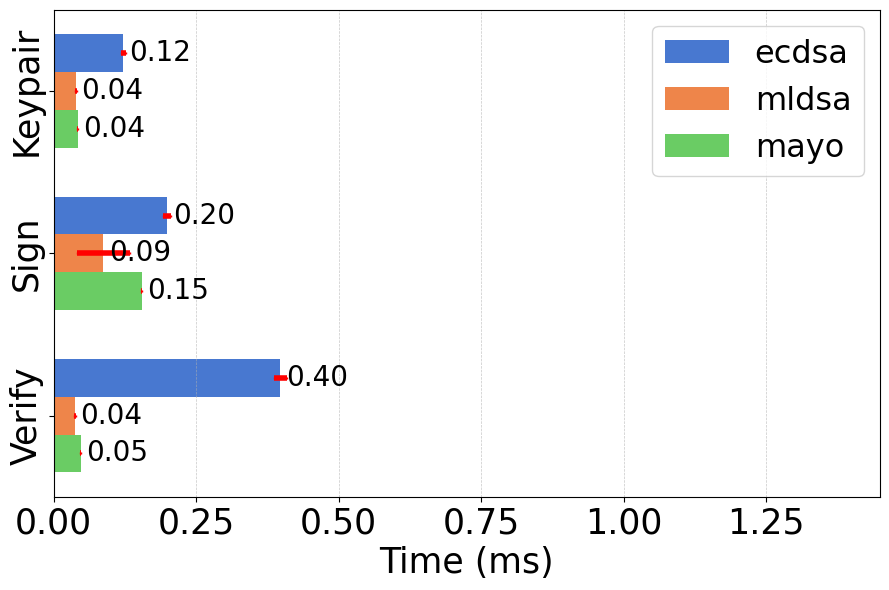

Processing deeppurple, level 5
Final algorithms: ['ecdsa', 'mldsa', 'mayo']
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
[('mean_verify', 'std_verify', 'Verify'), ('mean_sign', 'std_sign', 'Sign'), ('mean_keypair', 'std_keypair', 'Keypair')]
Saved: graficos/bench_deeppurple_level-5.pdf


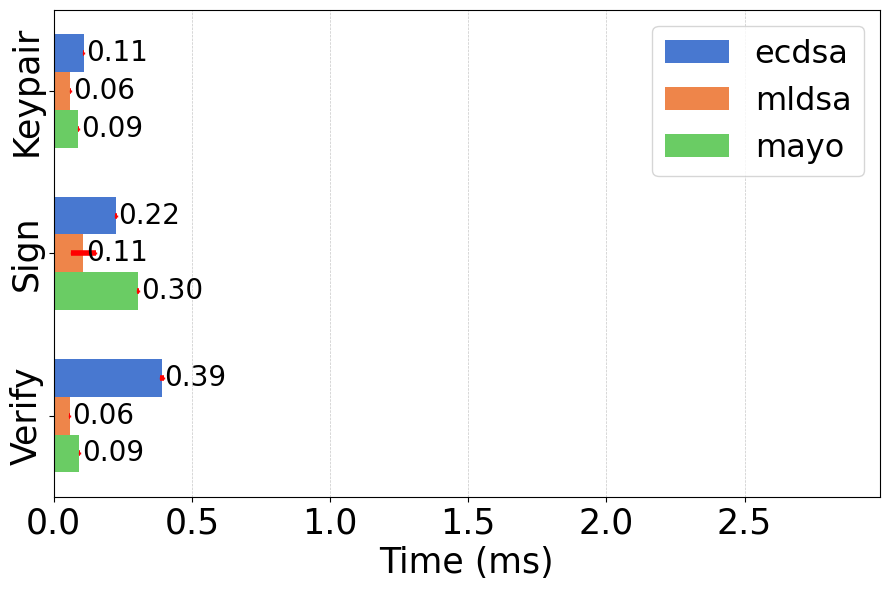

In [175]:
def plot_horizontal_multiple_inverted(
    dfs,                # lista de DataFrames
    columns,
    graphics_directory,
    values_offset,
    error_offset,
    levels=None,        # lista de níveis (opcional)
    xscale="linear",
    xlabel=None,
    xlim=None,
    xticks=None,
    yticklabels="operation",  # Agora são as operações no eixo Y
    figsize=None,
    width=0.7,
    titles=None,        # lista de títulos (opcional)
    ylabel=None,
    show_graph=False,
    show_values=True,
    show_errors=True,
    show_legend=True,
    save_formats=("pdf", "png"),
    file_name="multiples",
    pallet_start=0,
    legend_location="best"
):
    """
    Plota múltiplos gráficos horizontais em uma única figura, um para cada DataFrame da lista.
    Agora cada barra representa uma operação e os grupos representam os algoritmos.
    """
    n_plots = len(dfs)
    fig, axes = plt.subplots(1, 1, figsize=figsize, squeeze=False)
    axes = axes.flatten()
    fontsize = 25
    
    for idx, df in enumerate(dfs):
        # Obter lista de algoritmos únicos
        algorithms = df['algorithm'].unique()
        n_algorithms = len(algorithms)
        n_operations = len(columns)  # keypair, sign, verify
        
        width_bar = width / n_algorithms
        y = np.arange(n_operations)  # Agora y representa as operações
        ax = axes[idx]
        palette = sns.color_palette("muted", n_colors=len(algorithms) + pallet_start)
        
        # Para cada algoritmo
        for algo_idx, algorithm in enumerate(algorithms):
            color = palette[algo_idx + pallet_start]
            
            # Encontrar os dados para este algoritmo
            algo_data = df[df['algorithm'] == algorithm]
            if len(algo_data) == 0:
                continue
                
            # Coletar valores para todas as operações deste algoritmo
            values = []
            errors = []
            operation_labels = []
            print(columns)
             
            for i, (val_col, err_col, label) in enumerate(columns):
                if len(algo_data) > 0:
                    values.append(algo_data[val_col].iloc[0])
                    errors.append(algo_data[err_col].iloc[0])
                    operation_labels.append(label)
            
            bars = ax.barh(
                y + ((n_algorithms - 1 - algo_idx) - (n_algorithms - 1) / 2) * width_bar,
                values,
                height=width_bar,
                xerr=errors if show_errors else None,
                label=algorithm,  # Label é o nome do algoritmo
                color=color,
                error_kw={"capsize": 1, "ecolor": "red", "elinewidth": 4}
            )

            if show_values:
                for bar, value in zip(bars, values):
                    if value == 0:
                        ax.text(
                            0.1,
                            bar.get_y() + bar.get_height() / 2,
                            f"N/A",
                            va="center",
                            ha="right",
                            fontsize=fontsize-5,
                            color="black",
                        )
                    else:
                        ax.text(
                            value + values_offset,
                            bar.get_y() + bar.get_height() / 2,
                            f"{value:.2f}",
                            va="center",
                            ha="left",
                            fontsize=fontsize-5,
                            color="black",
                        )

        # Configurar labels do eixo Y com nomes das operações
        ax.set_yticks(y)
        operation_names = [col[2] for col in columns]  # Pega os nomes: "Keypair", "Sign", "Verify"
        ax.set_yticklabels(operation_names, rotation=90, va="center", fontsize=fontsize)

        if ylabel:
            ax.set_ylabel(ylabel, fontsize=fontsize)
        if xlabel:
            ax.set_xlabel(xlabel, fontsize=fontsize)
        if titles and idx < len(titles):
            ax.set_title(titles[idx], fontsize=fontsize)

        ax.set_xscale(xscale)
        if xscale == "log" and xticks is not None:
            ax.set_xticks(xticks)
        if xscale == "linear" and xlim:
            ax.set_xlim(*xlim)
        
        if len(y) > 0:
            ax.set_ylim(y[0] - 0.5, y[-1] + 0.5)
        
        ax.tick_params(axis="y", labelsize=fontsize)
        ax.tick_params(axis="x", labelsize=fontsize)
        if show_legend:
            ax.legend(loc=legend_location, fontsize=fontsize-2)
        ax.grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    
    for ext in save_formats:
        file = f"{graphics_directory}/{file_name}.{ext}"
        plt.savefig(file, format=ext, bbox_inches='tight')
        print(f"Saved: {file}")

    if show_graph:
        plt.show()
    plt.close()


columns = [
    ("mean_verify", "std_verify", "Verify"),
    ("mean_sign", "std_sign", "Sign"),
    ("mean_keypair", "std_keypair", "Keypair")
    ]

sign = """ecdsa
    mldsa
   mayo 
    """
sign_list = [s.strip() for s in sign.split()]
print("All algorithms loaded:", list(all_algorithms.keys()))
filtered_algorithms = filter_algorithms(all_algorithms, sign_list, levels)
print("Filtered algorithms:", filtered_algorithms)
combined_mechanisms = {}
for algorithm in filtered_algorithms.values():
    combined_mechanisms.update(algorithm)

print("Combined mechanisms:", combined_mechanisms)

# Uso da função invertida:
for m in ["a9", "airm1", "airm2", "laptop-windows-wsl", "xps-9320", "deeppurple"]:
    df_ethereum = results[m]["time-evaluation-mean-std"]
    variants_by_level = get_variants_by_level(df_ethereum, combined_mechanisms)
    
    for level, variants in variants_by_level.items():
        print(f"Processing {m}, level {level}")
        
        variant_to_algorithm = {v["variant"]: v["algorithm"] for v in variants}
        variant_names = [v["variant"] for v in variants]
        
        df_ethereum_subset = df_ethereum.loc[variant_names].copy()
        df_ethereum_subset["algorithm"] = df_ethereum_subset.index.map(variant_to_algorithm)
        
        # Adicionar algoritmos faltantes
        for s in sign_list:
            if s not in df_ethereum_subset["algorithm"].values:
                print(f"Adding missing algorithm: {s}")
                new_row = {}
                for col in df_ethereum_subset.columns:
                    if col != "algorithm":
                        new_row[col] = 0.0
                    else:
                        new_row[col] = s
                new_row["variant"] = f"N/A-{s}"
                new_row_df = pd.DataFrame([new_row]).set_index("variant")
                df_ethereum_subset = pd.concat([df_ethereum_subset, new_row_df])
        
        # Ordenar por algoritmo
        df_ethereum_subset["algorithm"] = pd.Categorical(
            df_ethereum_subset["algorithm"], 
            categories=sign_list, 
            ordered=True
        )
        df_ethereum_subset = df_ethereum_subset.sort_values("algorithm")
        
        print(f"Final algorithms: {df_ethereum_subset['algorithm'].tolist()}")
        print(columns)
         
        
        xlims={1:.99, 3:1.45, 5:2.99} 
        # Usar a função invertida
        plot_horizontal_multiple_inverted(
            dfs=[df_ethereum_subset],
            columns=columns,
            graphics_directory=OUTPUT_DIR,
            values_offset=0.01,
            error_offset=0,
            xscale="linear",
            xlabel="Time (ms)",
            xlim=(0, xlims[level]),
            yticklabels="operation",
            figsize=(9, 6),
            width=0.7,
            # ylabel="Operations",
            show_graph=True,
            show_values=True,
            show_errors=True,
            show_legend=True,
            save_formats=["pdf"],
            file_name=f"bench_{m}_level-{level}"
        )

All algorithms loaded: ['cryptography', 'liboqs']
Filtered algorithms: {'cryptography': {'ecdsa': {1: 'P-256', 3: 'P-384', 5: 'P-521'}}, 'liboqs': {'mldsa': {1: 'ML-DSA-44', 3: 'ML-DSA-65', 5: 'ML-DSA-87'}, 'mayo': {1: 'MAYO-2', 3: 'MAYO-3', 5: 'MAYO-5'}}}
Combined mechanisms: {'ecdsa': {1: 'P-256', 3: 'P-384', 5: 'P-521'}, 'mldsa': {1: 'ML-DSA-44', 3: 'ML-DSA-65', 5: 'ML-DSA-87'}, 'mayo': {1: 'MAYO-2', 3: 'MAYO-3', 5: 'MAYO-5'}}
Processing results for deeppurple: dict_keys(['time-evaluation-mean-std', 'blocksim-mean-std', 'blocksim-model-2-mean-std', 'blocksim-model-1-mean-std'])
Processing results for airm2: dict_keys(['time-evaluation-mean-std', 'blocksim-mean-std', 'blocksim-model-2-mean-std', 'blocksim-model-1-mean-std'])
Processing results for xps-9320: dict_keys(['time-evaluation-mean-std', 'blocksim-mean-std', 'blocksim-model-2-mean-std', 'blocksim-model-1-mean-std'])
Processing results for a9: dict_keys(['time-evaluation-mean-std', 'blocksim-mean-std', 'blocksim-model-2-mean-s

KeyError: 'Bitcoin_mean_verify'

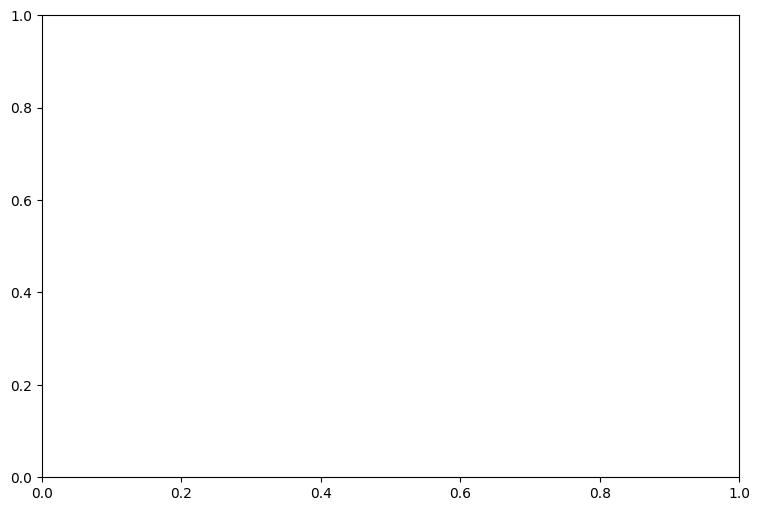

In [176]:
all_algorithms = ALGORITHMS
levels = [1, 3, 5]

sign = """ecdsa
    mldsa
    mayo
    """
sign_list = [s.strip() for s in sign.split()]

print("All algorithms loaded:", list(all_algorithms.keys()))
filtered_algorithms = filter_algorithms(all_algorithms, sign_list, levels)
print("Filtered algorithms:", filtered_algorithms)
combined_mechanisms = {}
for algorithm in filtered_algorithms.values():
    combined_mechanisms.update(algorithm)

print("Combined mechanisms:", combined_mechanisms)

columns = [
        ("mean_verify", "std_verify", "Ethereum"),
        ("Bitcoin_mean_verify", "Bitcoin_std_verify", "Bitcoin"),
    ]
for r in results.keys():
    print(f"Processing results for {r}: {results[r].keys()}")  


print("All algorithms loaded:", list(all_algorithms.keys()))
# for m in ["a9", "airm1", "airm2", "laptop-windows-wsl",  "xps-9320", "deeppurple"]:

for m in ["laptop-windows-wsl"]:
    df_ethereum = results[m]["blocksim-model-2-mean-std"]
    df_bitcoin = results[m]["blocksim-model-1-mean-std"]
    variants_by_level = get_variants_by_level(df_ethereum, combined_mechanisms)
    print("Variants by level:", variants_by_level)
    dfs = []
    
    for level, variants in variants_by_level.items():
        print(f"\tProcessing level {level} with variants: {variants}")
        variant_to_algorithm = {v["variant"]: v["algorithm"] for v in variants}
        print("Variant to Algorithm mapping:", variant_to_algorithm)
        variant_names = [v["variant"] for v in variants]
        
        df_ethereum_subset = df_ethereum.loc[variant_names].copy()  # Explicit copy to avoid SettingWithCopyWarning
        df_bitcoin_subset = df_bitcoin.loc[variant_names].copy()

        # Map algorithm names
        df_ethereum_subset["algorithm"] = df_ethereum_subset.index.map(variant_to_algorithm)
        
        # Add missing algorithms BEFORE creating algorithm2
        for s in sign_list:
            if s not in df_ethereum_subset["algorithm"].values:
                new_row = {col: 0.000000000000 for col in df_ethereum_subset.columns}
                new_row["algorithm"] = s
                new_row["variant"] = f"N/A-{s}"
                new_row_df = pd.DataFrame([new_row]).set_index("variant")
                df_ethereum_subset = pd.concat([df_ethereum_subset, new_row_df])
         
        # Now create algorithm2 after all rows exist
        df_ethereum_subset["algorithm2"] = df_ethereum_subset.apply(
            lambda x: f"{x['algorithm']}\n({x.name})" if "N/A" not in str(x.name) 
                     else x['algorithm'],
            axis=1
        )
        
        df_ethereum["Bitcoin_mean_verify"] = df_bitcoin["mean_verify"]
        df_ethereum["Bitcoin_std_verify"] = df_bitcoin["std_verify"]
         

        # Sort and categorize
        df_ethereum_subset["algorithm"] = pd.Categorical(
            df_ethereum_subset["algorithm"], 
            categories=sign_list, 
            ordered=True
        )
        df_ethereum_subset = df_ethereum_subset.sort_values("algorithm")
        
        print("\nDataFrame with algorithm column:\n", df_ethereum_subset)
        #dfs.append(df_subset)

        xscale = "linear"
        xlabel = "Time (ms)"
        
        xticks = None
        # yticklabels = "variant" if "variant" in df.columns else df.index.name
        yticklabels = "algorithm"  # if "variant" in df.columns else df.index.name

        width = 0.7
         
        ylabel = None
        save_formats = ["pdf"]
        print(df_ethereum_subset)
         
        #log_xticks=np.logspace(-3, 4, num=8, base=10) 
        #log_xlim=(1e-3, 1e3) 
        xlims={1:160, 3:1499, 5:1799}
        plot_horizontal_multiple_inverted(
            dfs=[df_ethereum_subset],
            columns=columns,
            graphics_directory=OUTPUT_DIR,
            values_offset=3,
            error_offset=0,
            levels=levels,
            figsize=(9, 6),
            # levels=levels,
            xscale=xscale,
            xlabel=xlabel,
            xlim=(0, xlims[level]),
            yticklabels=yticklabels,
            width=width,
            titles=None,
            ylabel=ylabel,
            show_graph=True,
            show_values=True,
            show_errors=True,
            show_legend=True,
             
            save_formats=save_formats,
            file_name=f"sim_{m}_level-{level}",
            pallet_start=0,
            legend_location="lower right" 
                        )

         